In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,fbeta_score, confusion_matrix

In [2]:
import xgboost as xgb
import sqlite3
from tqdm import tqdm
import seaborn as sns

In [3]:
import pickle
from collections import Counter
from gensim.models import Word2Vec

C:\Users\karth\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### inputs

In [4]:
con = sqlite3.connect('final.sqlite')

In [5]:
df = pd.read_sql_query('''
SELECT * FROM Reviews
WHERE SCORE !=3
''', con)

In [6]:
sorted_df = df.sort_values(by='Time')

In [7]:
sorted_df.Score.replace(to_replace=[1,2], value=0, inplace=True)

In [8]:
sorted_df.Score.replace(to_replace=[5,4], value=1, inplace=True)

In [9]:
sorted_df['Score'].value_counts()

1    307063
0     57110
Name: Score, dtype: int64

In [10]:
y_train = sorted_df.Score[0:100000]

In [11]:
y_train.value_counts()

1    87731
0    12269
Name: Score, dtype: int64

In [12]:
x_train = sorted_df.CleanedText[0:100000]

### pickie

In [13]:
pickle_out = open('x_train_100k.pickle','wb')
pickle.dump(x_train,pickle_out)

In [14]:
pickle_out = open('y_train_100k.pkl','wb')
pickle.dump(y_train,pickle_out)

In [15]:
countvec = CountVectorizer(min_df=5,stop_words='english', max_features=10000)

In [16]:
std_bow_train = countvec.fit_transform(x_train)

In [17]:
tfidf = TfidfVectorizer(min_df=5,stop_words='english', max_features=10000)

In [18]:
std_tfidf_train = tfidf.fit_transform(x_train)

In [19]:
listofsentences = []
for sent in x_train:
    listofsentences.append(sent.split())

In [20]:
training_model = Word2Vec(sentences = listofsentences, workers=3)

In [21]:
model_words = list(training_model.wv.vocab)

In [22]:
std_avgw2v_train = []
for everysentence in tqdm(listofsentences):
    count = 0
    sentence = np.zeros(100)
    for everyword in everysentence:
        if everyword in model_words:
            w2v = training_model.wv[everyword]
            count+=1
            sentence+=w2v
            
    if count !=0:
        sentence/=count
        std_avgw2v_train.append(sentence)

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [02:19<00:00, 715.63it/s]


In [23]:
len(std_avgw2v_train)

100000

In [24]:
tfidfmodel = TfidfVectorizer()
tf_idf_matrix = tfidfmodel.fit_transform(x_train)
tfidf_feat = tfidfmodel.get_feature_names()

In [25]:
dictionary = dict(zip(tfidfmodel.get_feature_names(), list(tfidfmodel.idf_)))

In [26]:
std_tfidfw2v_train = []
row=0
for everysentence in tqdm(listofsentences):
    weighted_sum = 0
    sentence = np.zeros(100)
    for everyword in everysentence:
        if everyword in model_words:
            w2v = training_model.wv[everyword]
            tf_idf = dictionary[everyword]*(everysentence.count(everyword)/len(everysentence))
            sentence += (w2v*tf_idf)
            weighted_sum+=tf_idf
    
    if weighted_sum !=0:
        sentence /= weighted_sum
    std_tfidfw2v_train.append(sentence)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [02:51<00:00, 584.24it/s]


### testing set

### we are taking the values between 165000 and 185000 specifically because this is the range in which the difference between labels 1 and 0 is the least

In [27]:
x_test = sorted_df.CleanedText[100000:120000]

In [28]:
x_test.shape

(20000,)

In [29]:
y_test = sorted_df.Score[100000:120000]

In [30]:
y_test.shape

(20000,)

In [31]:
Counter(y_test)

Counter({1: 16876, 0: 3124})

### bow,tfidf,avgw2v and tfidfw2v for x_test

In [32]:
countvec = CountVectorizer(min_df=5, max_features=10000)

In [33]:
cv = countvec.fit(x_train)

In [34]:
std_bow_test = cv.transform(x_test)

In [35]:
tfidf = TfidfVectorizer(min_df=5, max_features=10000)

In [36]:
vectorizer = tfidf.fit(x_train)

In [37]:
std_tfidf_test = vectorizer.transform(x_test)

In [38]:
test_list = []
for sent in x_test:
    test_list.append(sent.split())

In [39]:
training_model = Word2Vec(sentences = listofsentences, min_count=3, workers=-1)

In [40]:
model_words = list(training_model.wv.vocab)

In [41]:
testing = []
for everysentence in tqdm(test_list):
    count = 0
    sentence = np.zeros(100)
    for everyword in everysentence:
        if everyword in model_words:
            w2v = training_model.wv[everyword]
            count+=1
            sentence+=w2v
            
    if count !=0:
        sentence/=count
        testing.append(sentence)

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:28<00:00, 690.31it/s]


In [42]:
tfidfmodel = TfidfVectorizer()
tf_idf_matrix = tfidfmodel.fit_transform(x_train)
tfidf_feat = tfidfmodel.get_feature_names()

In [43]:
dictionary = dict(zip(tfidfmodel.get_feature_names(), list(tfidfmodel.idf_)))

In [44]:
training_model = Word2Vec(sentences = listofsentences, min_count=3, workers=-1)

In [45]:
weightedtest = []
row=0
for everysentence in tqdm(test_list):
    weighted_sum = 0
    sentence = np.zeros(100)
    for everyword in everysentence:
        if everyword in model_words:
            w2v = training_model.wv[everyword]
            tf_idf = dictionary[everyword]*(everysentence.count(everyword)/len(everysentence))
            sentence += (w2v*tf_idf)
            weighted_sum+=tf_idf
    
    if weighted_sum !=0:
        sentence /= weighted_sum
    weightedtest.append(sentence)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:32<00:00, 617.91it/s]


### Random forest classifier

## CountVectorizer

In [181]:
clf = RandomForestClassifier(n_jobs=-1)

In [182]:
params = [{'n_estimators':[int(x) for x in np.linspace(start=10, stop=200, num=20)]},{'max_depth':[5,8,11,13,15,17,19]},{'max_features':['auto','sqrt']}]

In [184]:
model = GridSearchCV(estimator=clf, param_grid=params, scoring='f1',cv=5, n_jobs=-1,verbose=1)

In [185]:
model.fit(std_bow_train, y_train)

Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed: 116.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]}, {'max_depth': [5, 8, 11, 13, 15, 17, 19]}, {'max_features': ['auto', 'sqrt']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [186]:
model.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [187]:
model.best_score_

0.9465983473167555

### applying learned values

In [155]:
clf = RandomForestClassifier(n_estimators=30, max_features='auto')

In [156]:
clf.fit(std_bow_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [190]:
y_pred = clf.predict(std_bow_test)

In [191]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  68.88


In [192]:
print('the precision score on testing set is ', precision_score(y_test, y_pred, average='micro')*100)

the precision score on testing set is  68.88


In [193]:
print('the recall score on testing set is ', recall_score(y_test, y_pred, average='micro')*100)

the recall score on testing set is  68.88


In [194]:
cmat = confusion_matrix(y_test, y_pred)

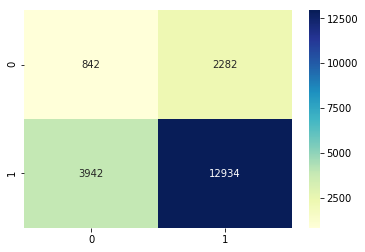

In [195]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### roc

In [196]:
y_pred_prob = clf.predict_proba(std_bow_test)[:,1]

In [197]:
from sklearn.metrics import roc_curve,roc_auc_score

In [198]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

In [199]:
import matplotlib.pyplot as plt

Text(0.5,1,'ROC Curve')

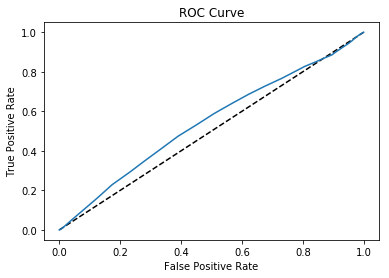

In [200]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

### feature importance

In [157]:
d = {}

In [158]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.feature_importances_, feature_names))
    top = coefs_with_fns[:-(n + 1):-1]
    for i, (coef_1, fn_1)in enumerate(top):
#         print ("\t%.4f\t%-15s" % (coef_1, fn_1))
        d[fn_1] = coef_1

In [159]:
show_most_informative_features(countvec,clf)

In [160]:
from wordcloud import WordCloud

In [161]:
wc = WordCloud()

In [162]:
wc.fit_words(d)

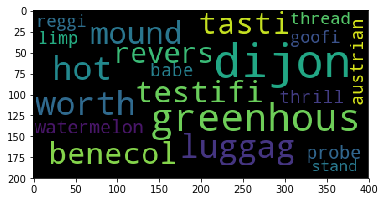

In [163]:
plt.imshow(wc)

## TFIDF

In [90]:
clf = RandomForestClassifier(n_jobs=-1, min_samples_split=)

In [94]:
params = [{'n_estimators':[int(x) for x in np.linspace(start=10, stop=200, num=20)]},{'max_depth':[5,8,11,13,15,17,19]},{'max_features':['auto','sqrt']}, {'min_samples_split':[2,3,4]}]

In [95]:
model = GridSearchCV(estimator=clf, param_grid=params, scoring='f1',cv=5, n_jobs=-1,verbose=1)

In [96]:
model.fit(std_tfidf_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 96.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]}, {'max_depth': [5, 8, 11, 13, 15, 17, 19]}, {'max_features': ['auto', 'sqrt']}, {'min_samples_split': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [97]:
model.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [98]:
model.best_score_

0.9453292710831427

### applying learned values

In [136]:
clf = RandomForestClassifier(n_estimators=20, max_features='auto')

In [137]:
clf.fit(std_tfidf_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [150]:
y_pred = clf.predict(std_tfidf_test)

In [102]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  87.0675


In [103]:
print('the precision score on testing set is ', precision_score(y_test, y_pred, average='micro')*100)

the precision score on testing set is  87.0675


In [104]:
print('the recall score on testing set is ', recall_score(y_test, y_pred, average='micro')*100)

the recall score on testing set is  87.0675


In [105]:
cmat = confusion_matrix(y_test, y_pred)

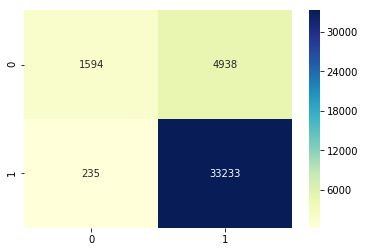

In [106]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### roc

In [107]:
y_pred_prob = clf.predict_proba(std_tfidf_test)[:,1]

In [108]:
from sklearn.metrics import roc_curve,roc_auc_score

In [109]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

Text(0.5,1,'ROC Curve')

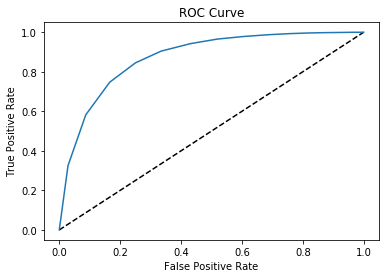

In [110]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

### important features

In [141]:
d_test ={}

In [149]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.feature_importances_, feature_names))
    top = coefs_with_fns[:-(n + 1):-1]
    for i, (coef_1, fn_1)in enumerate(top):
        d[coef_1] = fn_1
#         print ("\t%.4f\t%-15s" % (coef_1, fn_1))
        d_test[fn_1] = coef_1

In [150]:
show_most_informative_features(tfidf,clf)

In [151]:
from wordcloud import WordCloud

In [152]:
wc = WordCloud()

In [153]:
wc.fit_words(d_test)

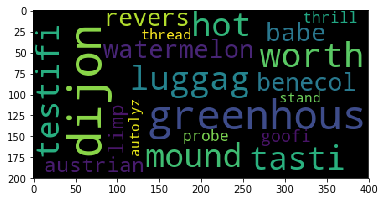

In [154]:
plt.imshow(wc)

## AVGW2V

In [52]:
clf = RandomForestClassifier(n_jobs=-1,)

In [53]:
params = [{'n_estimators':[int(x) for x in np.linspace(start=10, stop=200, num=20)]},{'max_depth':[5,8,11,13,15,17,19]},{'max_features':['auto','sqrt']}, {'min_samples_split':[2,3,4]}]

In [54]:
model = GridSearchCV(estimator=clf, param_grid=params, scoring='f1',cv=5, n_jobs=-1,verbose=1)

In [55]:
model.fit(std_avgw2v_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 74.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]}, {'max_depth': [5, 8, 11, 13, 15, 17, 19]}, {'max_features': ['auto', 'sqrt']}, {'min_samples_split': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [56]:
model.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [57]:
model.best_score_

0.9450237607470703

### applying learned values

In [133]:
clf = RandomForestClassifier(n_estimators=150, max_features='auto',min_samples_split=5, min_samples_leaf=1,verbose=1)

In [134]:
clf.fit(std_avgw2v_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  2.9min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [46]:
y_pred = clf.predict(testing)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished


In [47]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  84.38


In [48]:
print('the precision score on testing set is ', precision_score(y_test, y_pred, average='micro')*100)

the precision score on testing set is  84.38


In [49]:
print('the recall score on testing set is ', recall_score(y_test, y_pred, average='micro')*100)

the recall score on testing set is  84.38


In [50]:
cmat = confusion_matrix(y_test, y_pred)

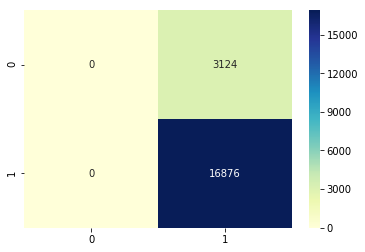

In [51]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### roc

In [66]:
y_pred_prob = clf.predict_proba(testing)[:,1]

In [67]:
from sklearn.metrics import roc_curve,roc_auc_score

In [68]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

Text(0.5,1,'ROC Curve')

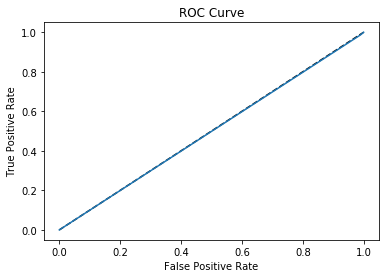

In [71]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

### smote

In [52]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [53]:
smote = SMOTE(n_jobs=2, random_state=10, ratio=1.0,)

In [54]:
x_sampled,y_sampled = smote.fit_sample(std_avgw2v_train, y_train)

In [55]:
Counter(y_sampled)

Counter({1: 87731, 0: 87731})

In [79]:
clf = RandomForestClassifier(max_depth=3,min_samples_split=2, random_state=42,n_jobs=-1)

In [80]:
clf.fit(x_sampled, y_sampled)

C:\Users\karth\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [81]:
y_pred = clf.predict(testing)

In [82]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  15.620000000000001


In [83]:
cmat = confusion_matrix(y_test, y_pred)

In [84]:
Counter(y_test)

Counter({1: 16876, 0: 3124})

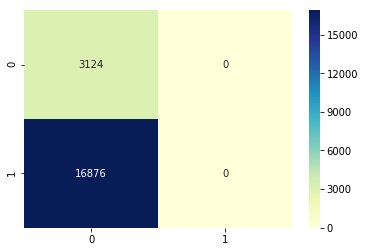

In [85]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### grid searching

In [62]:
resampled_y = y_sampled[43000:143000]

In [63]:
Counter(resampled_y)

Counter({1: 49481, 0: 50519})

In [64]:
resampled_x = x_sampled[43000:143000,:]

In [65]:
clf = RandomForestClassifier(n_estimators=150, max_features='auto',min_samples_split=5, min_samples_leaf=1,verbose=1)

In [67]:
params = [{'n_estimators':[int(x) for x in np.linspace(start=10, stop=200, num=20)]},{'max_depth':[5,8,11,13,15,17,19]},{'max_features':['auto','sqrt']}, {'min_samples_split':[2,3,4]}]

In [68]:
model = GridSearchCV(estimator=clf, param_grid=params, scoring='f1',cv=5, n_jobs=-1,verbose=1)

In [69]:
model.fit(resampled_x,resampled_y)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 117.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  2.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]}, {'max_depth': [5, 8, 11, 13, 15, 17, 19]}, {'max_features': ['auto', 'sqrt']}, {'min_samples_split': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [70]:
model.best_params_

{'min_samples_split': 2}

In [71]:
model.best_score_

0.9152188998453755

### applying learned values

In [72]:
clf = RandomForestClassifier(n_estimators=150, max_features='auto',min_samples_split=2, min_samples_leaf=1,verbose=1)

In [73]:
clf.fit(resampled_x,resampled_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  3.0min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [74]:
pred = clf.predict(testing)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished


In [75]:
print('f1 score for testing set is ', f1_score(y_test, pred, average='micro')*100)

f1 score for testing set is  84.38


In [76]:
cmat = confusion_matrix(y_test, y_pred)

In [77]:
Counter(y_test)

Counter({1: 16876, 0: 3124})

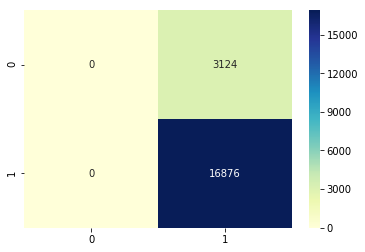

In [78]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### neamiss

In [222]:
nm = NearMiss(n_jobs=-1, random_state=10, ratio=1.0)

In [223]:
x_sampled,y_sampled = nm.fit_sample(std_tfidfw2v_train, y_train)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [224]:
Counter(y_sampled)

Counter({0: 12269, 1: 12269})

In [225]:
clf = RandomForestClassifier(max_depth=3,min_samples_split=2, random_state=42,n_jobs=-1)

In [233]:
clf.fit(x_sampled, y_sampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [234]:
y_pred = clf.predict(weightedtest)

In [235]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  84.38


In [236]:
cmat = confusion_matrix(y_test, y_pred)

In [237]:
Counter(y_test)

Counter({1: 16876, 0: 3124})

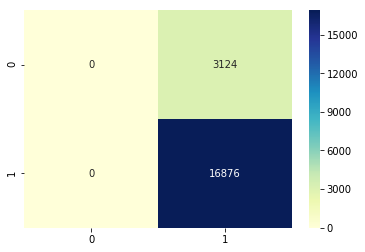

In [238]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### important features

In [135]:
d = {}

In [125]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.feature_importances_, feature_names))
    top = coefs_with_fns[:-(n + 1):-1]
    for i, (coef_1, fn_1)in enumerate(top):
        print ("\t%.4f\t%-15s" % (coef_1, fn_1))
        d[coef_1] = fn_1

In [127]:
show_most_informative_features(countvec,clf)

	0.0159	dijon          
	0.0099	greenhous      
	0.0079	worth          
	0.0078	revers         
	0.0073	watermelon     
	0.0070	luggag         
	0.0067	tasti          
	0.0067	austrian       
	0.0064	testifi        
	0.0064	thrill         
	0.0063	babe           
	0.0061	hot            
	0.0054	benecol        
	0.0053	mound          
	0.0051	goofi          
	0.0051	limp           
	0.0049	reggi          
	0.0048	probe          
	0.0046	thread         
	0.0045	receptionist   


In [117]:
newdict={}
for k,v in d.items():
    newdict[v] = (k)

In [118]:
newdict

{'dijon': 0.014666705230128174,
 'greenhous': 0.009356028933272562,
 'worth': 0.008459148913277415,
 'luggag': 0.007587181080399522,
 'testifi': 0.006582429155915876,
 'watermelon': 0.006536393831533946,
 'hot': 0.00636811769490388,
 'tasti': 0.006332463749658444,
 'benecol': 0.006026535544178446,
 'revers': 0.005478952563845547,
 'babe': 0.005463098086852198,
 'mound': 0.00494747487438907,
 'austrian': 0.004735223170564302,
 'probe': 0.004636910401445764,
 'thrill': 0.0046246043458517795,
 'goofi': 0.004523963542798558,
 'limp': 0.0043574564100954775,
 'receptionist': 0.003979854918718255,
 'stand': 0.0039128106603461225,
 'reggi': 0.003789250919861918}

In [128]:
from wordcloud import WordCloud

In [129]:
wc = WordCloud()

In [130]:
wc.fit_words(newdict)

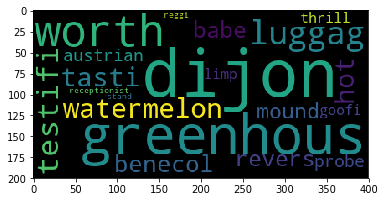

In [131]:
plt.imshow(wc)

### TFIDFW2V

In [72]:
clf = RandomForestClassifier(n_jobs=-1)

In [73]:
params = [{'n_estimators':[int(x) for x in np.linspace(start=10, stop=200, num=20)]},{'max_depth':[5,8,11,13,15,17,19]},{'max_features':['auto','sqrt']}, {'min_samples_split':[2,3,4]}]

In [74]:
model = GridSearchCV(estimator=clf, param_grid=params, scoring='f1',cv=5, n_jobs=-1,verbose=1)

In [75]:
model.fit(std_tfidfw2v_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 74.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]}, {'max_depth': [5, 8, 11, 13, 15, 17, 19]}, {'max_features': ['auto', 'sqrt']}, {'min_samples_split': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [76]:
model.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [77]:
model.best_score_

0.9419979049302705

### applying learned values

In [138]:
Counter(y_train)

Counter({1: 87731, 0: 12269})

In [161]:
weights={0:5, 1:0.5}

In [78]:
clf = RandomForestClassifier(n_estimators=50, max_features='auto')

In [79]:
clf.fit(std_tfidfw2v_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [80]:
y_pred = clf.predict(weightedtest)

In [81]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  82.96


In [82]:
print('the precision score on testing set is ', precision_score(y_test, y_pred, average='micro')*100)

the precision score on testing set is  82.96


In [83]:
print('the recall score on testing set is ', recall_score(y_test, y_pred, average='micro')*100)

the recall score on testing set is  82.96


In [84]:
cmat = confusion_matrix(y_test, y_pred)

In [169]:
Counter(y_test)

Counter({1: 16592, 0: 3408})

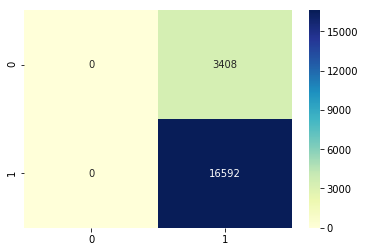

In [85]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### smote

In [90]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [91]:
smote = SMOTE(n_jobs=-1, random_state=10, ratio=1.0,)

In [93]:
x_sampled,y_sampled = smote.fit_sample(std_tfidfw2v_train, y_train)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [208]:
Counter(y_sampled)

Counter({1: 87731, 0: 87731})

In [94]:
resampled_y = y_sampled[43000:143000]

In [207]:
Counter(resampled_y)

Counter({1: 49481, 0: 50519})

In [95]:
resampled_x = x_sampled[43000:143000,:]

In [215]:
clf = RandomForestClassifier(max_depth=3,min_samples_split=2, random_state=42,n_jobs=-1)

In [216]:
clf.fit(resampled_x, resampled_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [217]:
y_pred = clf.predict(weightedtest)

In [218]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  15.620000000000001


In [219]:
cmat = confusion_matrix(y_test, y_pred)

In [220]:
Counter(y_test)

Counter({1: 16876, 0: 3124})

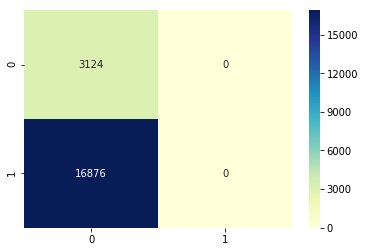

In [221]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### neamiss

In [222]:
nm = NearMiss(n_jobs=-1, random_state=10, ratio=1.0)

In [223]:
x_sampled,y_sampled = nm.fit_sample(std_tfidfw2v_train, y_train)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [224]:
Counter(y_sampled)

Counter({0: 12269, 1: 12269})

In [225]:
clf = RandomForestClassifier(max_depth=3,min_samples_split=2, random_state=42,n_jobs=-1)

In [233]:
clf.fit(x_sampled, y_sampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [234]:
y_pred = clf.predict(weightedtest)

In [235]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  84.38


In [236]:
cmat = confusion_matrix(y_test, y_pred)

In [237]:
Counter(y_test)

Counter({1: 16876, 0: 3124})

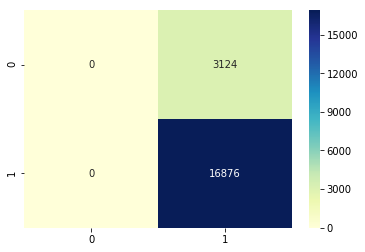

In [238]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### roc

In [239]:
y_pred_prob = clf.predict_proba(weightedtest)[:,1]

In [54]:
from sklearn.metrics import roc_curve,roc_auc_score

In [240]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

Text(0.5,1,'ROC Curve')

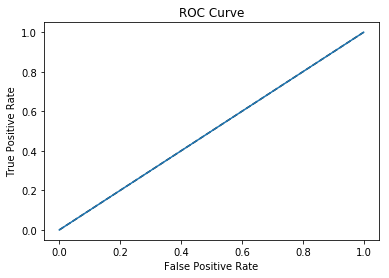

In [241]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# feature importance - Count vectorizer

In [171]:
con = sqlite3.connect('final.sqlite')

In [172]:
df = pd.read_sql_query('''
SELECT * FROM Reviews
WHERE SCORE !=3
''', con)

In [21]:
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,5,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,5,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [173]:
df.shape

(364173, 12)

In [174]:
df.Score.replace(to_replace=[1,2], value=0, inplace=True)

In [175]:
df.Score.value_counts()

5    250966
0     57110
4     56097
Name: Score, dtype: int64

In [176]:
df.Score.replace(to_replace=[5,4], value=1, inplace=True)

In [177]:
df.Score.value_counts()

1    307063
0     57110
Name: Score, dtype: int64

In [178]:
positivereviews = df[df.Score == 1]

In [179]:
positivereviews.shape

(307063, 12)

In [180]:
positivereviews.Score.value_counts()

1    307063
Name: Score, dtype: int64

In [181]:
negativereviews = df[df.Score == 0]

In [182]:
negativereviews.Score.value_counts()

0    57110
Name: Score, dtype: int64

In [183]:
postext = positivereviews.CleanedText

In [184]:
negtext = negativereviews.CleanedText

In [185]:
countvect = CountVectorizer(min_df=5, stop_words='english')

In [186]:
positivebow = countvect.fit(positivereviews.CleanedText[0:100000])

In [187]:
pos_xtrain = positivebow.transform(positivereviews.CleanedText[100000:200000])

In [188]:
pos_xtrain.shape

(100000, 11451)

In [189]:
pos_y = positivereviews.Score[100000:200000]

In [190]:
pos_y.value_counts()

1    100000
Name: Score, dtype: int64

### feature importance

In [191]:
clf = RandomForestClassifier()

In [212]:
clf.fit(std_bow_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [213]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    feature_log_with_fns = sorted(zip(clf.feature_importances_, feature_names))
    top =  feature_log_with_fns[:-(n + 1):-1]
    for (coef_1, fn_1) in top:
        print ("\t%.4f\t%-15s" % (coef_1, fn_1))

In [214]:
show_most_informative_features(vectorizer=countvect, clf=clf)

	0.0115	dishwat        
	0.0112	grubbi         
	0.0078	zamouri        
	0.0078	lyn            
	0.0068	roach          
	0.0062	ticket         
	0.0061	bestest        
	0.0061	tex            
	0.0060	moutard        
	0.0058	hungarian      
	0.0056	awak           
	0.0054	public         
	0.0048	wide           
	0.0044	litter         
	0.0044	gradual        
	0.0043	bah            
	0.0042	tong           
	0.0041	tomato         
	0.0036	repeat         
	0.0035	twinki         


In [103]:
from collections import Counter

In [130]:
Counter(clf.feature_importances_)

Counter({0.0: 63514})

### tfidf feature importance

In [207]:
clf = RandomForestClassifier()

In [208]:
clf.fit(std_tfidf_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [209]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.feature_importances_, feature_names))
    top = coefs_with_fns[:-(n + 1):-1]
    for (coef_1, fn_1)in top:
        print ("\t%.4f\t%-15s" % (coef_1, fn_1))

In [210]:
show_most_informative_features(vectorizer=countvect, clf=clf)

	0.0133	dishwat        
	0.0118	grubbi         
	0.0103	zamouri        
	0.0084	ticket         
	0.0081	tong           
	0.0078	lyn            
	0.0076	tex            
	0.0073	hungarian      
	0.0071	wide           
	0.0067	bah            
	0.0067	moutard        
	0.0057	roach          
	0.0056	litter         
	0.0052	public         
	0.0052	gradual        
	0.0049	bestest        
	0.0047	tomato         
	0.0042	repeat         
	0.0040	stirfri        
	0.0038	flovor         


In [115]:
Counter(clf.feature_importances_)

Counter({0.0: 9922})

## feature importance - Tfidf vectorizer

In [117]:
tfidf = TfidfVectorizer(min_df=2, max_features=2000)

In [118]:
positivetfidf = tfidf.fit(positivereviews.CleanedText)

In [119]:
pos_xtrain = positivetfidf.transform(positivereviews.CleanedText)

In [120]:
pos_xtrain.shape

(307063, 2000)

In [121]:
pos_y = positivereviews.Score

In [122]:
pos_y.value_counts()

1    307063
Name: Score, dtype: int64

In [123]:
clf = DecisionTreeClassifier(max_depth=3, min_samples_split=2)

In [124]:
clf.fit(pos_xtrain, pos_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [125]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.feature_importances_, feature_names))
    top = coefs_with_fns[:-(n + 1):-1]
    for (coef_1, fn_1)in top:
        print ("\t%.4f\t%-15s" % (coef_1, fn_1))

In [126]:
show_most_informative_features(vectorizer=countvect, clf=clf)

	0.0000	zico           
	0.0000	zero           
	0.0000	yummi          
	0.0000	yuk            
	0.0000	yucki          
	0.0000	yuck           
	0.0000	young          
	0.0000	yogurt         
	0.0000	yesterday      
	0.0000	yes            
	0.0000	yellow         
	0.0000	yeast          
	0.0000	year           
	0.0000	yeah           
	0.0000	yard           
	0.0000	xylitol        
	0.0000	www            
	0.0000	wrote          
	0.0000	wrong          
	0.0000	written        


### negative reviews

In [127]:
tfidf = TfidfVectorizer(min_df=2, max_features=2000)

In [128]:
negativetfidf = tfidf.fit(negativereviews.CleanedText)

In [129]:
neg_xtrain = negativetfidf.transform(negativereviews.CleanedText)

In [130]:
neg_xtrain.shape

(57110, 2000)

In [131]:
neg_y = negativereviews.Score

In [133]:
neg_y.value_counts()

0    57110
Name: Score, dtype: int64

In [134]:
clf = DecisionTreeClassifier(max_depth=3, min_samples_split=2)

In [135]:
clf.fit(neg_xtrain, neg_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [136]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.feature_importances_, feature_names))
    top = coefs_with_fns[:-(n + 1):-1]
    for (coef_1, fn_1)in top:
        print ("\t%.4f\t%-15s" % (coef_1, fn_1))

In [137]:
show_most_informative_features(vectorizer=countvect, clf=clf)

	0.0000	zico           
	0.0000	zero           
	0.0000	yummi          
	0.0000	yuk            
	0.0000	yucki          
	0.0000	yuck           
	0.0000	young          
	0.0000	yogurt         
	0.0000	yesterday      
	0.0000	yes            
	0.0000	yellow         
	0.0000	yeast          
	0.0000	year           
	0.0000	yeah           
	0.0000	yard           
	0.0000	xylitol        
	0.0000	www            
	0.0000	wrote          
	0.0000	wrong          
	0.0000	written        


### XGBoost

### xgboost count vectorizer

In [86]:
import warnings
warnings.filterwarnings('ignore')

In [87]:
from collections import Counter
Counter(y_train)

Counter({1: 87731, 0: 12269})

In [44]:
from xgboost import XGBClassifier

In [45]:
clf = XGBClassifier(n_jobs=-1,colsample_bylevel=0.6, subsample=0.8, random_state=42)

In [55]:
params={'learning_rate':[0.1,0.2,0.3,0.4],'n_estimators':[int(x) for x in np.linspace(start=10, stop=250, num=20)], 'max_depth':[3,4,5],'tree_method': ['gpu_exact']}

In [56]:
model = GridSearchCV(estimator=clf, param_grid=params, cv=5, n_jobs=-1, scoring='f1',verbose=1)

In [57]:
model.fit(std_bow_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 38.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 97.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 187.5min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 296.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.4], 'n_estimators': [10, 22, 35, 47, 60, 73, 85, 98, 111, 123, 136, 148, 161, 174, 186, 199, 212, 224, 237, 250], 'max_depth': [3, 4, 5], 'tree_method': ['gpu_exact']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [58]:
model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=1, gamma=0, learning_rate=0.4, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=22,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8, tree_method='gpu_exact')

In [59]:
model.best_score_

0.9352966440139575

In [60]:
model.best_params_

{'learning_rate': 0.4,
 'max_depth': 4,
 'n_estimators': 22,
 'tree_method': 'gpu_exact'}

In [130]:
clf = XGBClassifier(learning_rate=0.4, max_depth=4, n_estimators=85,n_jobs=-1,colsample_bylevel=0.6, subsample=0.8, random_state=42)

In [131]:
clf.fit(std_bow_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=1, gamma=0, learning_rate=0.4, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=85,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

In [132]:
pred = clf.predict(std_bow_test)

In [133]:
print('f1 score on testing set is ', f1_score(y_test, pred, average='micro')*100)

f1 score on testing set is  78.655


In [134]:
print('precision score on testing set is ', precision_score(y_test, pred, average='micro')*100)

precision score on testing set is  78.655


In [135]:
print('recall score on testing set is ', recall_score(y_test, pred, average='micro',)*100)

recall score on testing set is  78.655


In [136]:
cmat = confusion_matrix(y_test, pred)

In [137]:
Counter(y_test)

Counter({1: 16876, 0: 3124})

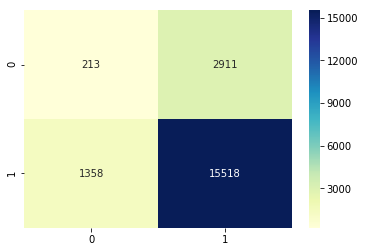

In [138]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### roc

In [139]:
y_pred_prob = clf.predict_proba(std_bow_test)[:,1]

In [140]:
from sklearn.metrics import roc_curve,roc_auc_score

In [141]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

Text(0.5,1,'ROC Curve')

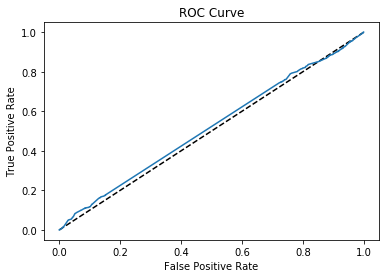

In [142]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [143]:
roc_auc_score(y_test, y_pred_prob)

0.5179230143406497

### xgboost tfidf

In [46]:
from xgboost import XGBClassifier

In [47]:
clf = XGBClassifier(n_jobs=-1,colsample_bylevel=0.6, subsample=0.8, random_state=42)

In [52]:
params={'learning_rate':[0.1,0.2,0.3,0.4],'n_estimators':[int(x) for x in np.linspace(start=10, stop=250, num=20)], 'max_depth':[3,4,5],'tree_method': ['gpu_exact']}

In [53]:
model = GridSearchCV(estimator=clf, param_grid=params, cv=5, n_jobs=-1, scoring='f1',verbose=1)

In [50]:
import warnings
warnings.filterwarnings('ignore')

In [54]:
model.fit(std_tfidf_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 43.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 83.5min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 130.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.4], 'n_estimators': [10, 22, 35, 47, 60, 73, 85, 98, 111, 123, 136, 148, 161, 174, 186, 199, 212, 224, 237, 250], 'max_depth': [3, 4, 5], 'tree_method': ['gpu_exact']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [55]:
model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=1, gamma=0, learning_rate=0.4, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=35,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8, tree_method='gpu_exact')

In [56]:
model.best_score_

0.9351014701342715

In [57]:
model.best_params_

{'learning_rate': 0.4,
 'max_depth': 4,
 'n_estimators': 35,
 'tree_method': 'gpu_exact'}

In [84]:
clf = XGBClassifier(learning_rate=0.4, max_depth=4, n_estimators=35,n_jobs=-1,colsample_bylevel=0.6, subsample=0.8, random_state=42)

In [85]:
clf.fit(std_tfidf_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=1, gamma=0, learning_rate=0.4, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=35,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

In [86]:
pred = clf.predict(std_tfidf_test)

In [87]:
print('f1 score on testing set is ', f1_score(y_test, pred, average='micro')*100)

f1 score on testing set is  80.205


In [88]:
print('precision score on testing set is ', precision_score(y_test, pred, average='micro')*100)

precision score on testing set is  80.205


In [89]:
print('recall score on testing set is ', recall_score(y_test, pred, average='micro',)*100)

recall score on testing set is  80.205


In [90]:
cmat = confusion_matrix(y_test, pred)

In [91]:
Counter(y_test)

Counter({1: 16876, 0: 3124})

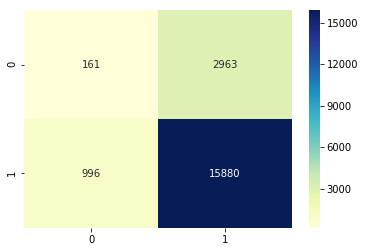

In [92]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### roc

In [93]:
y_pred_prob = clf.predict_proba(std_tfidf_test)[:,1]

In [94]:
from sklearn.metrics import roc_curve,roc_auc_score

In [95]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

Text(0.5,1,'ROC Curve')

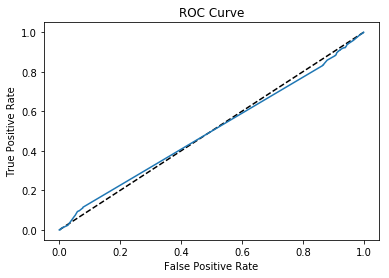

In [96]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

### avgw2v

In [35]:
from xgboost import XGBClassifier

In [38]:
clf = XGBClassifier(n_jobs=-1,colsample_bylevel=0.6, subsample=0.8, random_state=42)

In [43]:
params={'learning_rate':[0.1,0.2,0.3,0.4],'n_estimators':[int(x) for x in np.linspace(start=10, stop=250, num=20)], 'max_depth':[3,4,5],'tree_method': ['gpu_hist']}

In [44]:
model = GridSearchCV(estimator=clf, param_grid=params, cv=5, n_jobs=-1, scoring='f1',verbose=1)

In [45]:
newavgw2v = np.asmatrix(std_avgw2v_train)

In [48]:
import warnings
warnings.filterwarnings('ignore')

In [49]:
model.fit(newavgw2v, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 52.1min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 80.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.4], 'n_estimators': [10, 22, 35, 47, 60, 73, 85, 98, 111, 123, 136, 148, 161, 174, 186, 199, 212, 224, 237, 250], 'max_depth': [3, 4, 5], 'tree_method': ['gpu_hist']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [50]:
model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=224,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8, tree_method='gpu_hist')

In [51]:
model.best_score_

0.9363970947924812

In [52]:
model.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 224,
 'tree_method': 'gpu_hist'}

In [53]:
clf = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=224,n_jobs=-1,colsample_bylevel=0.6, subsample=0.8, random_state=42)

In [54]:
clf.fit(newavgw2v, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=224,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

In [55]:
pred = clf.predict(testing)

In [56]:
print('f1 score on testing set is ', f1_score(y_test, pred, average='micro')*100)

f1 score on testing set is  85.02499999999999


In [57]:
print('precision score on testing set is ', precision_score(y_test, pred, average='micro')*100)

precision score on testing set is  85.02499999999999


In [58]:
print('recall score on testing set is ', recall_score(y_test, pred, average='micro',)*100)

recall score on testing set is  85.02499999999999


In [59]:
cmat = confusion_matrix(y_test, pred)

In [121]:
Counter(y_test)

Counter({1: 16876, 0: 3124})

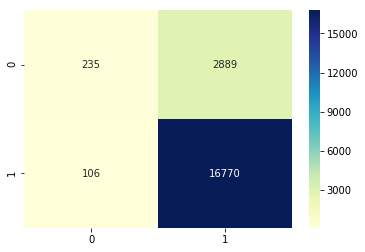

In [60]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### roc

In [61]:
y_pred_prob = clf.predict_proba(testing)[:,1]

In [62]:
from sklearn.metrics import roc_curve,roc_auc_score

In [63]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

Text(0.5,1,'ROC Curve')

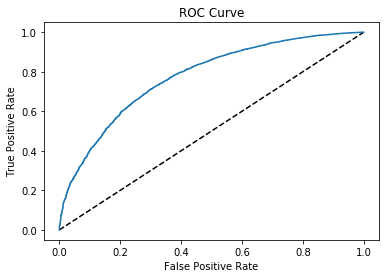

In [64]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

### tfidfw2v

In [44]:
from xgboost import XGBClassifier

In [45]:
clf = XGBClassifier(n_jobs=-1,colsample_bylevel=0.6, subsample=0.8, random_state=42)

In [46]:
params={'learning_rate':[0.1,0.2,0.3,0.4],'n_estimators':[int(x) for x in np.linspace(start=10, stop=250, num=20)], 'max_depth':[3,4,5],'tree_method': ['gpu_hist']}

In [223]:
x_sampled,y_sampled = nm.fit_sample(std_tfidfw2v_train, y_train)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [224]:
Counter(y_sampled)

Counter({0: 12269, 1: 12269})

In [225]:
clf = RandomForestClassifier(max_depth=3,min_samples_split=2, random_state=42,n_jobs=-1)

In [233]:
clf.fit(x_sampled, y_sampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [234]:
y_pred = clf.predict(weightedtest)

In [235]:
print('f1 score for testing set is ', f1_score(y_test, y_pred, average='micro')*100)

f1 score for testing set is  84.38


In [236]:
cmat = confusion_matrix(y_test, y_pred)

In [237]:
Counter(y_test)

Counter({1: 16876, 0: 3124})

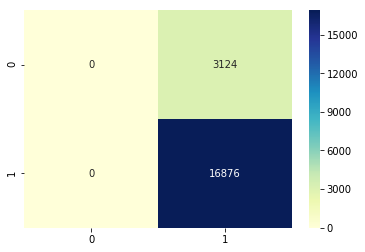

In [238]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### roc

In [239]:
y_pred_prob = clf.predict_proba(weightedtest)[:,1]

In [54]:
from sklearn.metrics import roc_curve,roc_auc_score

In [240]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

Text(0.5,1,'ROC Curve')

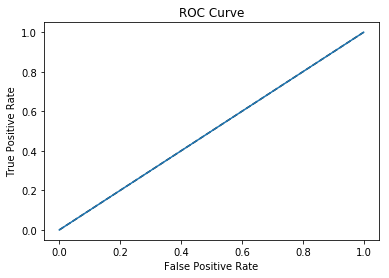

In [241]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [47]:
model = GridSearchCV(estimator=clf, param_grid=params, cv=5, n_jobs=-1, scoring='f1',verbose=1)

In [52]:
tfidfw2v = np.asmatrix(std_tfidfw2v_train)

In [49]:
import warnings
warnings.filterwarnings('ignore')

In [54]:
model.fit(tfidfw2v, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 27.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 51.1min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 79.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.4], 'n_estimators': [10, 22, 35, 47, 60, 73, 85, 98, 111, 123, 136, 148, 161, 174, 186, 199, 212, 224, 237, 250], 'max_depth': [3, 4, 5], 'tree_method': ['gpu_hist']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [55]:
model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8, tree_method='gpu_hist')

In [56]:
model.best_score_

0.9347033542699192

In [57]:
model.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 250,
 'tree_method': 'gpu_hist'}

In [58]:
clf = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=250,n_jobs=-1,colsample_bylevel=0.6, subsample=0.8, random_state=42)

In [59]:
clf.fit(tfidfw2v, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

In [60]:
pred = clf.predict(weightedtest)

In [61]:
print('f1 score on testing set is ', f1_score(y_test, pred, average='micro')*100)

f1 score on testing set is  84.375


In [62]:
print('precision score on testing set is ', precision_score(y_test, pred, average='micro')*100)

precision score on testing set is  84.375


In [63]:
print('recall score on testing set is ', recall_score(y_test, pred, average='micro',)*100)

recall score on testing set is  84.375


In [64]:
cmat = confusion_matrix(y_test, pred)

In [65]:
Counter(y_test)

Counter({1: 16876, 0: 3124})

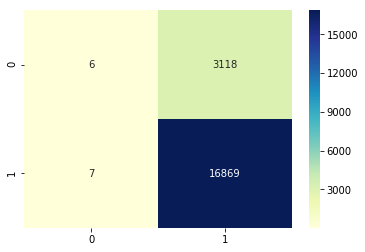

In [66]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### roc

In [67]:
y_pred_prob = clf.predict_proba(weightedtest)[:,1]

In [68]:
from sklearn.metrics import roc_curve,roc_auc_score

In [69]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

Text(0.5,1,'ROC Curve')

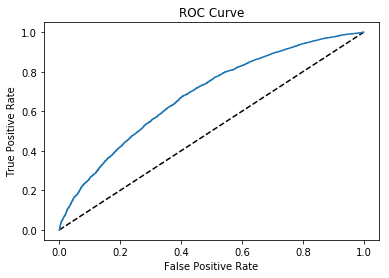

In [70]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

### simple cross validation

### Count vectorizer

In [46]:
import itertools

In [47]:
clf = RandomForestClassifier(n_jobs=-1)

In [48]:
n_estimators= 20,40,60,80,100,120,140,160,180,200
max_depth=2,3,5,7,9,11,13,15,17,19

In [179]:
train_roc=[]
for (a,b) in tqdm(itertools.product(n_estimators,max_depth)):
    clf = RandomForestClassifier(n_estimators=a, max_depth=b)
    clf.fit(std_bow_train, y_train)
    pred = clf.predict_proba(std_bow_test)[:,1]
    train_roc.append(roc_auc_score(y_test, pred))

100it [06:12, 10.26s/it]


In [236]:
df = pd.DataFrame(columns=['estimators', 'depth'])

In [237]:
for i,(a,b) in enumerate(itertools.product(n_estimators,max_depth)):
    df.loc[i] = [a,b]

In [238]:
df['roc'] = train_roc

In [291]:
roc1 = [[0.4946486 , 0.5195475 , 0.4988455 , 0.47747759, 0.52434151,0.53476946, 0.50667595, 0.52232085, 0.52780756, 0.50815008],
[0.51343908, 0.50075699, 0.49691188, 0.50108544, 0.51669259,0.50129107, 0.54763397, 0.52820153, 0.54443883, 0.52991311],
[0.50284209, 0.54420766, 0.51391265, 0.52117962, 0.52514598,0.53288252, 0.52966885, 0.54181605, 0.52074826, 0.55430816],
[0.48934713, 0.51174751, 0.52600505, 0.53985591, 0.52499087,0.56190159, 0.52659654, 0.54514492, 0.53689844, 0.55124163],
[0.5068149 , 0.51462757, 0.51505278, 0.52364042, 0.53116019,0.55523961, 0.53472977, 0.5486456 , 0.55785708, 0.55410348],
[0.50775569, 0.53216479, 0.53738931, 0.55327686, 0.56753662,0.56398873, 0.54582989, 0.54978491, 0.51614204, 0.54873999],
[0.52318941, 0.56397871, 0.52461497, 0.53721211, 0.56108274,0.54713317, 0.52153427, 0.53856013, 0.53920627, 0.55142475],
[0.53775822, 0.52523503, 0.51908565, 0.52950408, 0.52620361,0.53853958, 0.53298655, 0.5556541 , 0.5537419 , 0.55631039],
[0.52191183, 0.54998372, 0.5615636 , 0.55630351, 0.55575494,0.57197936, 0.55865998, 0.56554392, 0.55824371, 0.55728228],
[0.56046801, 0.55794059, 0.53152385, 0.53386567, 0.5401635 ,0.57103524, 0.55422247, 0.55058155, 0.54619262, 0.55171096]]

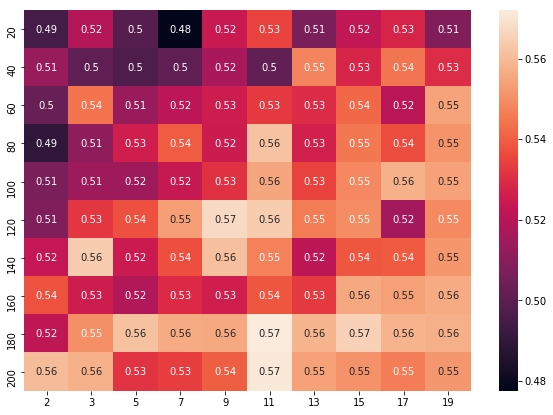

In [300]:
df_cm = pd.DataFrame(roc1, index = [i for i in range(20,220,20)],
                  columns = [i for i in (2,3,5,7,9,11,13,15,17,19)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

### tfidf

In [301]:
clf = RandomForestClassifier(n_jobs=-1)

In [302]:
n_estimators= 20,40,60,80,100,120,140,160,180,200
max_depth=2,3,5,7,9,11,13,15,17,19

In [311]:
train_roc=[]
for (a,b) in tqdm(itertools.product(n_estimators,max_depth)):
    clf = RandomForestClassifier(n_estimators=a, max_depth=b)
    clf.fit(std_tfidf_train, y_train)
    pred = clf.predict_proba(std_tfidf_test)[:,1]
    train_roc.append(roc_auc_score(y_test, pred))

100it [09:09, 14.93s/it]


In [314]:
arr = np.asarray(train_roc)

In [316]:
newarr = arr[:, np.newaxis]

In [317]:
newarr.shape

(100, 1)

In [318]:
newnew = newarr.reshape((10,10))

In [320]:
newnew.shape

(10, 10)

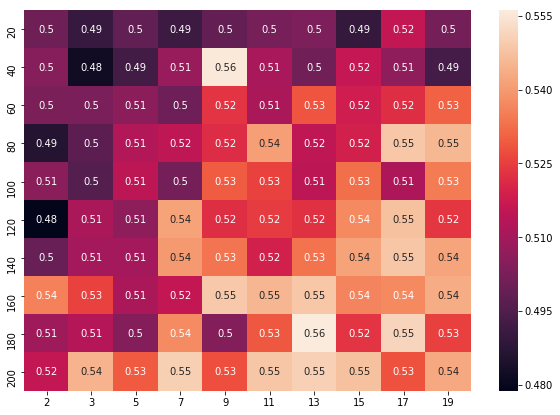

In [321]:
tfidf_df = pd.DataFrame(newnew, index = [i for i in range(20,220,20)],
                  columns = [i for i in (2,3,5,7,9,11,13,15,17,19)])
plt.figure(figsize = (10,7))
sns.heatmap(tfidf_df, annot=True)

### avgw2v

In [51]:
from sklearn.metrics import roc_auc_score

In [322]:
clf = RandomForestClassifier(n_jobs=-1)

In [49]:
n_estimators= 20,40,60,80,100,120,140,160,180,200
max_depth=2,3,5,7,9,11,13,15,17,19

In [52]:
train_roc=[]
for (a,b) in tqdm(itertools.product(n_estimators,max_depth)):
    clf = RandomForestClassifier(n_estimators=a, max_depth=b,n_jobs=-1)
    clf.fit(std_avgw2v_train, y_train)
    pred = clf.predict_proba(testing)[:,1]
    train_roc.append(roc_auc_score(y_test, pred))

100it [54:28, 77.74s/it]


In [53]:
arr = np.asarray(train_roc)

In [54]:
newarr = arr[:, np.newaxis]

In [55]:
newarr.shape

(100, 1)

In [56]:
newnew = newarr.reshape((10,10))

In [57]:
newnew.shape

(10, 10)

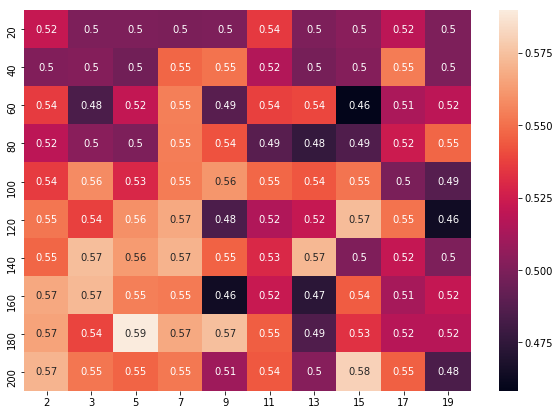

In [58]:
tfidf_df = pd.DataFrame(newnew, index = [i for i in range(20,220,20)],
                  columns = [i for i in (2,3,5,7,9,11,13,15,17,19)])
plt.figure(figsize = (10,7))
sns.heatmap(tfidf_df, annot=True)

### tfidfw2v

In [59]:
train_roc=[]
for (a,b) in tqdm(itertools.product(n_estimators,max_depth)):
    clf = RandomForestClassifier(n_estimators=a, max_depth=b,n_jobs=-1)
    clf.fit(std_tfidfw2v_train, y_train)
    pred = clf.predict_proba(weightedtest)[:,1]
    train_roc.append(roc_auc_score(y_test, pred))

100it [54:34, 78.73s/it]


In [60]:
arr = np.asarray(train_roc)

In [61]:
newarr = arr[:, np.newaxis]

In [62]:
newarr.shape

(100, 1)

In [63]:
newnew = newarr.reshape((10,10))

In [64]:
newnew.shape

(10, 10)

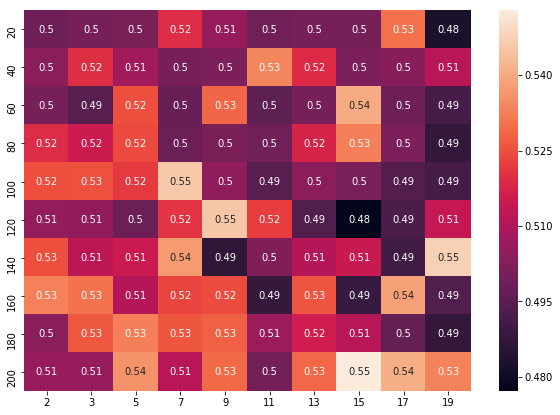

In [65]:
tfidf_df = pd.DataFrame(newnew, index = [i for i in range(20,220,20)],
                  columns = [i for i in (2,3,5,7,9,11,13,15,17,19)])
plt.figure(figsize = (10,7))
sns.heatmap(tfidf_df, annot=True)